This notebook is structures into three different parts:
1. Identify the most important features within each atmospheric field category regardless their spatial correlation. Here, we used random forests.
1. Then, we utilize an XGBoost model on all variables combined and evaluate its foehn diagnosis performance.
1. Lastly, we plot composite maps of for all atmospheric field categories, also injecting the determined feature importances here.

# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Packages
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Custom functions
from plot_mean_foehn_conditions import *
from utils import *
from model_training import *

# Import constants from constants.py file in directory above
import sys
sys.path.append("..")
from constants import *

# Define plotting style
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams.update({'font.size': 20})

--- Avaliable variables ---
Base directory: BASE_DIR
Month names: MONTH_NAMES
Bounding box coordinates: LON_MIN, LON_MAX, LAT_MIN, LAT_MAX
ERAI coordinates: LONS_ERA, LATS_ERA
CESM coordinates: LONS_CESM, LATS_CESM
CESM slice: INDEX_CESM
CESM coordinates for plotting (string): LONS_CESM_STRING, LATS_CESM_STRING


# Read ERA data

In [5]:
# Set location: ALT or LUG
location = "ALT" 

In [6]:
# Load ERA-Interim data
if location == "ALT":
    df_ERA_raw = pd.read_csv(os.path.join(BASE_DIR, "data/FoehnAndMeteorologicalData/ERAI_and_South_Foehn_Altdorf_data.csv.gz"), parse_dates=["date"])
elif location == "LUG":
    df_ERA_raw = pd.read_csv(os.path.join(BASE_DIR, "data/FoehnAndMeteorologicalData/ERAI_and_North_Foehn_LUG_data.csv.gz"), parse_dates=["date"])

In [7]:
df_ERA = df_ERA_raw.copy()  # Keep copy of original data
df_ERA = df_ERA.dropna().reset_index(drop=True)  # Drop any NaNs which might be there

In [8]:
# Create potential temperature features for given pressure levels (only run this cell once)
df_PHIT_900 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+900"))+273.15, p=900.0).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+850"))+273.15, p=850.0).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_ERA.filter(regex=("T_\w+700"))+273.15, p=700.0).add_prefix("PHI")
df_ERA = pd.concat([df_ERA, df_PHIT_900, df_PHIT_850, df_PHIT_700], axis=1)

del df_PHIT_900, df_PHIT_850, df_PHIT_700

# Fit RF models to each atmospheric field category and obtain importances

In [9]:
# Create train and test mask
test_mask = (df_ERA["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA["date"]<np.datetime64("2000-12-31 23:59"))
train_mask = (test_mask == False)

In [10]:
# Create dataframe to save feature importances from RF models in each variable field category
df_importances = pd.DataFrame(columns=["feature_name", "importance"])

In [11]:
# Set up basic RF model
model = RandomForestClassifier(n_estimators=1000, n_jobs=40, max_depth=7)

Started fitting ...
Finished fitting ...
--- Test set performance ---
Best threshold: 0.34867586320388727
[[13527   239]
 [  248   522]]
Accuracy: 0.9664969730324711
Precision: 0.6859395532194481
Recall: 0.6779220779220779
ROC-AUC: 0.9769810242060716
Log-Loss: 0.08054949934215676


,feature_name,importance
0,diff_SLP_4664_1125_sealevel_SLP_4759_750_sealevel,0.012084
1,diff_SLP_4570_1125_sealevel_SLP_4664_750_sealevel,0.012030
2,diff_SLP_4570_875_sealevel_SLP_4664_750_sealevel,0.011936
3,diff_SLP_4570_1000_sealevel_SLP_4664_750_sealevel,0.011921
4,diff_SLP_4664_1125_sealevel_SLP_4759_875_sealevel,0.010733
5,diff_SLP_4664_1250_sealevel_SLP_4759_875_sealevel,0.010027
6,diff_SLP_4664_1000_sealevel_SLP_4759_875_sealevel,0.009752
7,diff_SLP_4570_1250_sealevel_SLP_4759_750_sealevel,0.008851
8,diff_SLP_4570_1125_sealevel_SLP_4759_750_sealevel,0.008840
9,diff_SLP_4664_1250_sealevel_SLP_4759_750_sealevel,0.008822


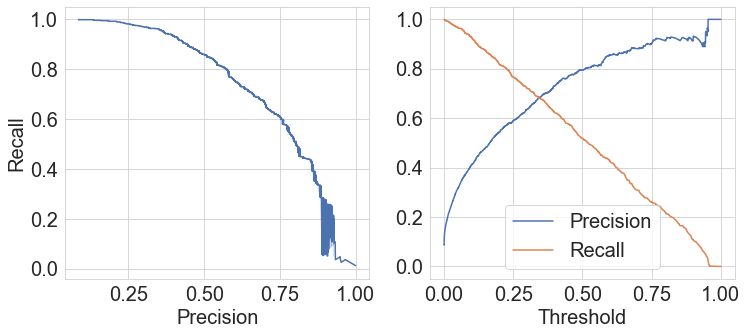

In [12]:
# Sealevel pressure differences
df_SLP_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="SLP", pressure_levels=["sealevel"])
df = df_SLP_diff.copy()
df["Foehn"] = df_ERA["Foehn"]

# Show model performance and obtain most important features (only run this cell once, since otherwise dataframe will flow over at some point)
df_importances_temp = fit_model_and_obtain_importances(model = model, df=df, feature_names = df.columns.drop("Foehn"), train_mask = train_mask, test_mask=test_mask)
df_importances = pd.concat([df_importances, df_importances_temp.head(30)], axis=0)

Started fitting ...
Finished fitting ...
--- Test set performance ---
Best threshold: 0.3272206968348239
[[13401   365]
 [  206   564]]
Accuracy: 0.9607182168409466
Precision: 0.6071044133476857
Recall: 0.7324675324675325
ROC-AUC: 0.9744495661247078
Log-Loss: 0.08340537092079874


,feature_name,importance
0,diff_Z_4570_875_850_Z_4664_750_850,0.013611
1,diff_Z_4570_750_850_Z_4570_875_850,0.012056
2,diff_Z_4476_875_850_Z_4570_625_850,0.009752
3,diff_Z_4570_875_850_Z_4664_625_850,0.009290
4,diff_Z_4570_1000_850_Z_4664_625_850,0.008997
5,diff_Z_4570_1125_850_Z_4664_750_850,0.008989
6,diff_Z_4476_1000_850_Z_4570_625_850,0.008669
7,diff_Z_4476_750_850_Z_4570_625_850,0.008141
8,diff_Z_4570_625_850_Z_4570_875_850,0.008023
9,diff_Z_4476_1125_850_Z_4664_625_850,0.007961


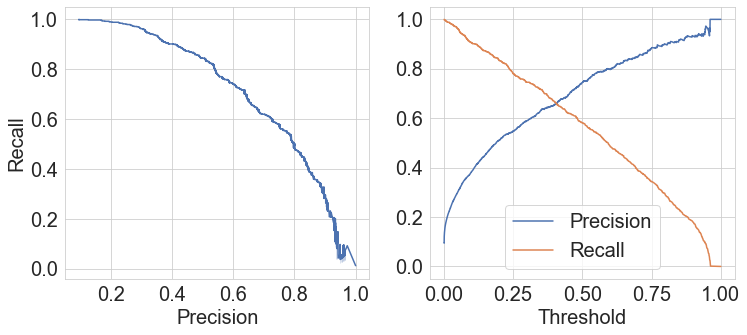

In [13]:
# Geopotential height differences (on 850 and 700 hPa)
df_Z_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="Z", pressure_levels=["850", "700"])
df = df_Z_diff.copy()
df["Foehn"] = df_ERA["Foehn"]

# Show model performance and obtain most important features (only run this cell once, since otherwise dataframe will flow over at some point)
df_importances_temp = fit_model_and_obtain_importances(model = model, df=df, feature_names = df.columns.drop("Foehn"), train_mask = train_mask, test_mask=test_mask)
df_importances = pd.concat([df_importances, df_importances_temp.head(30)], axis=0)

Started fitting ...
Finished fitting ...
--- Test set performance ---
Best threshold: 0.3524202725782877
[[13481   285]
 [  252   518]]
Accuracy: 0.9630572372041827
Precision: 0.6450809464508095
Recall: 0.6727272727272727
ROC-AUC: 0.9731407231443553
Log-Loss: 0.08622126865624442


,feature_name,importance
0,diff_PHIT_4476_750_850_PHIT_4759_1000_850,0.016959
1,diff_PHIT_4570_875_850_PHIT_4759_1000_850,0.015676
2,diff_PHIT_4570_875_850_PHIT_4759_875_850,0.013504
3,diff_PHIT_4570_875_850_PHIT_4759_1125_850,0.013057
4,diff_PHIT_4570_1000_850_PHIT_4759_1000_850,0.012988
5,diff_PHIT_4570_875_850_PHIT_4853_1000_850,0.011184
6,diff_PHIT_4570_1000_850_PHIT_4759_875_850,0.010521
7,diff_PHIT_4664_1000_850_PHIT_4759_1000_850,0.010444
8,diff_PHIT_4570_1000_850_PHIT_4853_1125_850,0.009235
9,diff_PHIT_4476_875_850_PHIT_4853_1000_850,0.009188


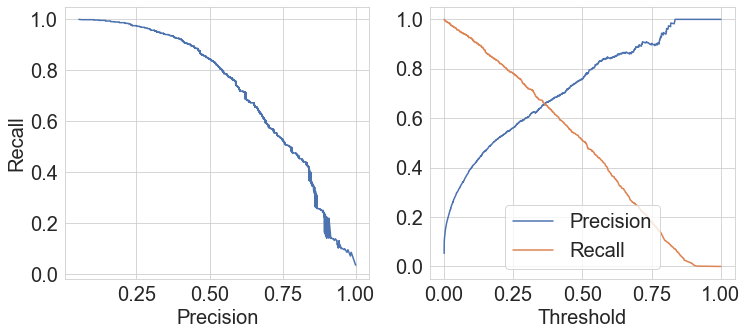

In [14]:
# Horizontal potential temperature differences (on 850 hPa)
df_PHIT_diff = calculate_horizontal_feature_differences(df=df_ERA, variable="PHIT", pressure_levels=["850"])
df = df_PHIT_diff.copy()
df["Foehn"] = df_ERA["Foehn"]

# Show model performance and obtain most important features (only run this cell once, since otherwise dataframe will flow over at some point)
df_importances_temp = fit_model_and_obtain_importances(model = model, df=df, feature_names = df.columns.drop("Foehn"), train_mask = train_mask, test_mask=test_mask)
df_importances = pd.concat([df_importances, df_importances_temp.head(30)], axis=0)

Started fitting ...
Finished fitting ...
--- Test set performance ---
Best threshold: 0.23206837569841493
[[13495   271]
 [  415   355]]
Accuracy: 0.9528068244358833
Precision: 0.5670926517571885
Recall: 0.461038961038961
ROC-AUC: 0.9374412961729539
Log-Loss: 0.12688614842484347


,feature_name,importance
0,DELTAPHI_4853_875_700,0.045321
1,DELTAPHI_4853_1000_700,0.043017
2,DELTAPHI_4853_750_700,0.038110
3,DELTAPHI_4476_875_700,0.033543
4,DELTAPHI_4476_750_700,0.031592
5,DELTAPHI_4853_1125_700,0.028138
6,DELTAPHI_4947_1000_700,0.027366
7,DELTAPHI_4570_875_700,0.026145
8,DELTAPHI_4759_625_700,0.023401
9,DELTAPHI_4570_750_700,0.023232


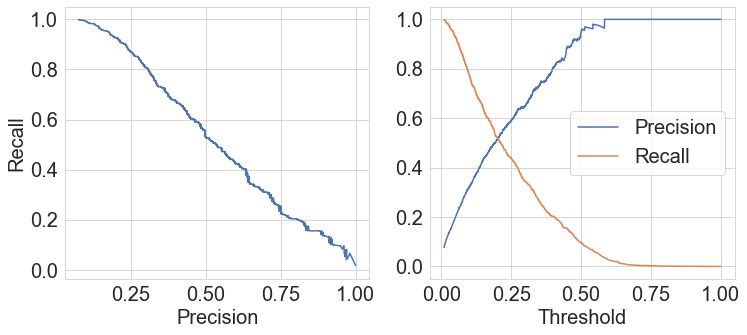

In [15]:
# Stability variables (between 850-900 hPa and 700-900 hPa)
df_stability = calculate_stability(df_ERA, lats=LATS_CESM_STRING, lons=LONS_CESM_STRING)
df = df_stability.copy()
df["Foehn"] = df_ERA["Foehn"]

# Show model performance and obtain most important features (only run this cell once, since otherwise dataframe will flow over at some point)
df_importances_temp = fit_model_and_obtain_importances(model = model, df=df, feature_names = df.columns.drop("Foehn"), train_mask = train_mask, test_mask=test_mask)
df_importances = pd.concat([df_importances, df_importances_temp.head(30)], axis=0)

Started fitting ...
Finished fitting ...
--- Test set performance ---
Best threshold: 0.30680157884480785
[[13426   340]
 [  230   540]]
Accuracy: 0.9607870115575123
Precision: 0.6136363636363636
Recall: 0.7012987012987013
ROC-AUC: 0.9725801947580243
Log-Loss: 0.08758887758316762


,feature_name,importance
0,V_4664_875_850,0.042011
1,V_4664_1000_850,0.037464
2,V_4476_500_700,0.025781
3,V_4476_500_850,0.024018
4,V_4570_625_700,0.023051
5,V_4382_500_850,0.021099
6,V_4570_500_700,0.020499
7,V_4476_625_700,0.019318
8,V_4664_500_700,0.018607
9,V_4570_750_700,0.016520


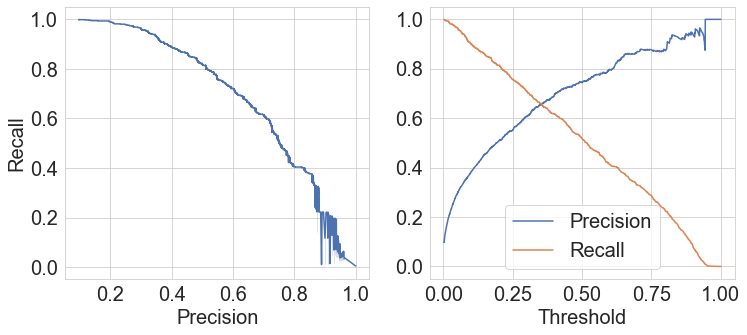

In [16]:
# Wind velocity variables (on 700 and 500 hPa)
df_wind = df_ERA.filter(regex=("(U|V)\w+")).copy()
df = df_wind.copy()
df["Foehn"] = df_ERA["Foehn"]

# Show model performance and obtain most important features (only run this cell once, since otherwise dataframe will flow over at some point)
df_importances_temp = fit_model_and_obtain_importances(model = model, df=df, feature_names = df.columns.drop("Foehn"), train_mask = train_mask, test_mask=test_mask)
df_importances = pd.concat([df_importances, df_importances_temp.head(30)], axis=0)

# Fit XGBoost classifier on whole data

In [17]:
# Concat all features to fit an XGBoost model to it
df_ERA_all_features = pd.concat([df_ERA[["date", "Foehn"]], 
                     df_SLP_diff, 
                     df_Z_diff, 
                     df_PHIT_diff, 
                     df_stability, 
                     df_wind], 
                    axis = 1)

In [ ]:
# Fit a global classifier on all features. The hyperparameters where determined from a CV which can also be run below.
model_xg = xgb.XGBClassifier(
                    max_depth=5,
                    learning_rate=0.2,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=1.0,
                    reg_lambda=100.0,
                    n_estimators=300,
                    verbosity=0,
                    nthread=40,
                    scale_pos_weight=20.0,
                    base_score=0.05,
                    seed=1337,
                    missing=None,
                  )
# CV params
params = {'max_depth': [2,3,4,5], 'learning_rate': [0.1, 0.2, 0.3], "reg_alpha": [0,10], "reg_lambda":[10,100]}

# Fit model and obtain feature importances
df_ERA_xgb_importances = fit_model_and_obtain_importances(model = model_xg, 
                                                              df=df_ERA_all_features, 
                                                              feature_names = df_ERA_all_features.columns.drop(["date", "Foehn"]), 
                                                              train_mask = train_mask, test_mask=test_mask, 
                                                              with_CV=False, parameters_CV=params)

In [19]:
# Print most important feature in LaTeX table format (for easy copying)
for i in range(10):
    string = df_ERA_xgb_importances.loc[i, "feature_name"].split("_")
    try:
        print(f"$\Delta {string[1]}$ & {int(string[2])/100}, {int(string[3])/100} - {int(string[6])/100}, {int(string[7])/100} & {string[4]} hPa & {str(df_ERA_xgb_importances.loc[i, 'importance'])[0:6]} \\") 
    except:
        print(f"$\Delta {string[1]}$ & {int(string[2])/100}, {int(string[3])/100} - {int(string[6])/100}, {int(string[7])/100} & {string[4]} hPa & {str(df_ERA_xgb_importances.loc[i, 'importance'])[0:6]} \\") 

$\Delta SLP$ & 45.7, 8.75 - 47.59, 8.75 & sealevel hPa & 0.3137 \
$\Delta Z$ & 45.7, 12.5 - 45.7, 7.5 & 850 hPa & 0.0971 \
$\Delta PHIT$ & 43.82, 3.75 - 47.59, 8.75 & 850 hPa & 0.0592 \
$\Delta SLP$ & 45.7, 10.0 - 47.59, 8.75 & sealevel hPa & 0.0588 \
$\Delta Z$ & 45.7, 8.75 - 46.64, 6.25 & 850 hPa & 0.0118 \
$\Delta SLP$ & 45.7, 10.0 - 48.53, 8.75 & sealevel hPa & 0.0095 \
$\Delta PHIT$ & 45.7, 11.25 - 47.59, 10.0 & 850 hPa & 0.0093 \
$\Delta Z$ & 45.7, 8.75 - 46.64, 7.5 & 850 hPa & 0.0084 \
$\Delta Z$ & 46.64, 7.5 - 48.53, 11.25 & 850 hPa & 0.0078 \
$\Delta Z$ & 47.59, 10.0 - 48.53, 11.25 & 850 hPa & 0.0066 \


# Plot composite maps

In [20]:
# Add stability variables to dataframe
df_ERA_with_stability = pd.concat([df_ERA, df_stability], axis=1)

In [21]:
# Define variables to be plotted, their respective limits ad units for each station
variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "K",
        "DELTAPHI": "K",
        "U": "m/s"}

if location == "ALT":
    v_limits = {"SLP": [1002, 1023],
                "Z": [1360, 1570],
                "T": [3+273, 10.5+273],
                "DELTAPHI": [5,12],
                "U":[5,15]}
elif location == "LUG":
    v_limits = {"SLP": [1009, 1027.5],
                "Z": [1420, 1581],
                "T": [-4+273, 7.05+273],
                "DELTAPHI": [4, 14.05],
                "U":[5,15]}

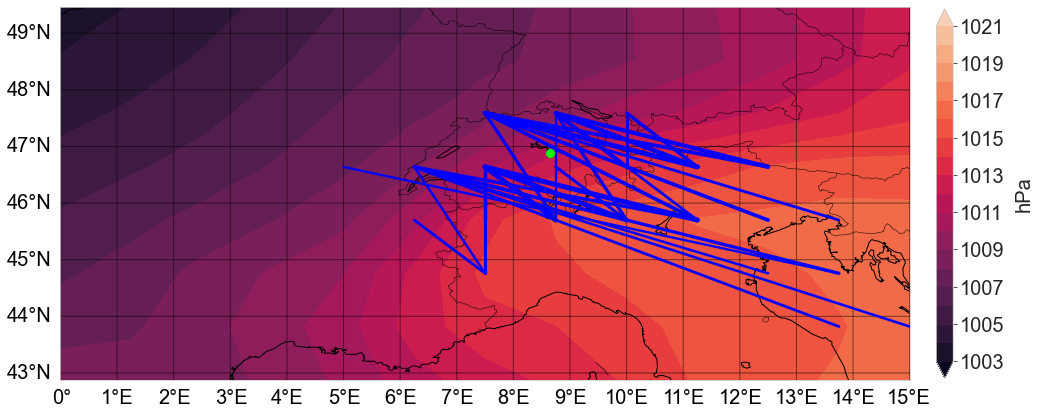

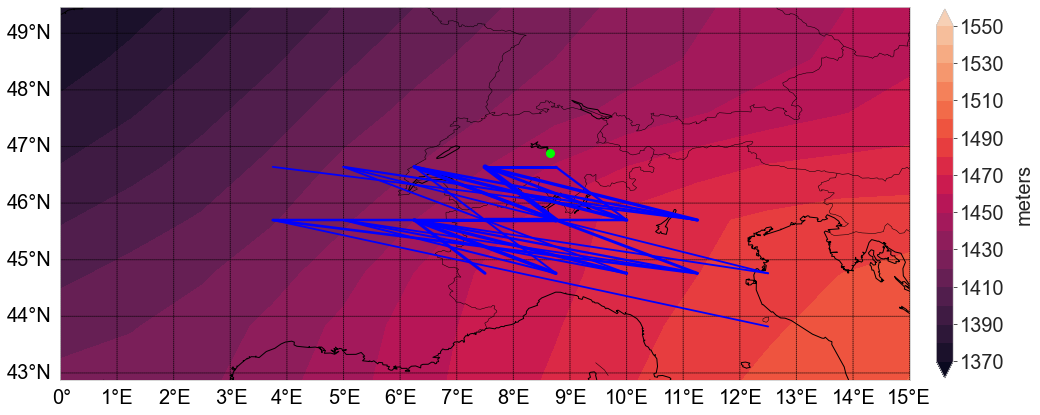

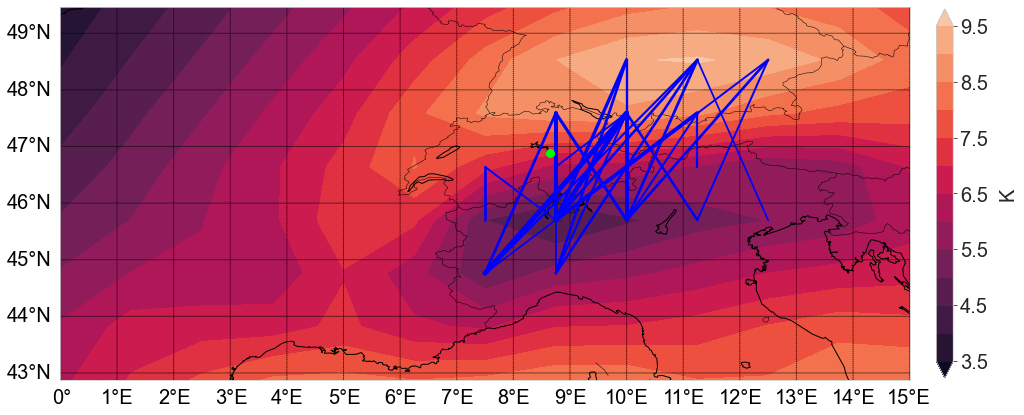

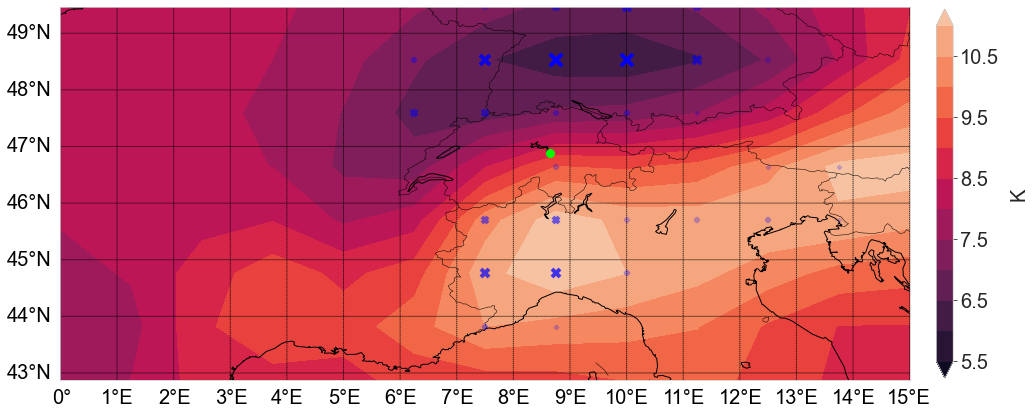

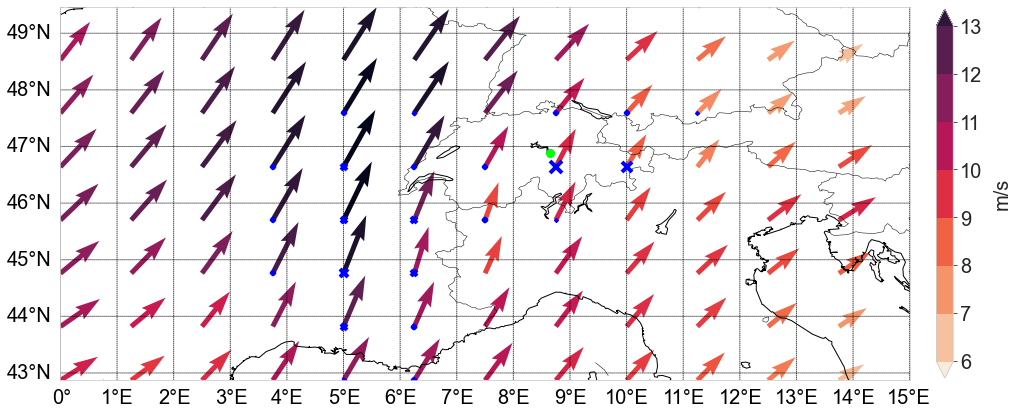

In [22]:
# Plot all variables and the feauture importances from the random forest models
for variable in list(variable_lvl.keys()):
    kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING,
          "df_importances": generate_coordinates_from_feature_label(dict(zip(df_importances["feature_name"], df_importances["importance"])), variable)}
    
    # Plot figures
    plt.figure(figsize=(16, 9))
    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model = location, 
                                            df = df_ERA_with_stability, 
                                            foehn = df_ERA_with_stability["Foehn"],
                                            location="ALT"
                                            )